# Tutorial 3: Representational geometry & noise

**Week 1, Day 3: Comparing Artificial And Biological Networks**

**By Neuromatch Academy**

__Content creators:__ Names & Surnames

__Content reviewers:__ Names & Surnames

__Production editors:__ Names & Surnames

<br>

Acknowledgments: [ACKNOWLEDGMENT_INFORMATION]



___


# Tutorial Objectives

*Estimated timing of tutorial: [insert estimated duration of whole tutorial in minutes]*

By completing this tutorial, you will gain insights into:

1. Generating neural data with varied noise distributions. This section will guide you through the process of creating neural data, introducing variability in noise distributions. This step is crucial for understanding how different noise levels can affect data representation and subsequent analyses.

2. Understanding distance metrics - eclidean and mahalanobis. We will delve into two fundamental distance measures - Euclidean and Mahalanobis distances. Understanding these metrics is essential for analyzing the spatial relationships between data points in a representation space, with each metric offering unique insights based on the nature of the data.

3. Exploring the relationship between distance metrics and binary classification performance. This part of the tutorial emphasizes the significant relationship between distance measurements and the performance of binary classification tasks on a given pair of stimuli. Understanding this relationship is vital for developing more accurate and robust classification models.

4. Addressing positively biased estimators through crossvalidation. We will explore the concept of positively biased estimators that arise when computing distances based on noisy pattern estimates. You will learn how crossvalidation techniques can be employed to correct this bias, ensuring a more accurate estimation of the underlying noise-free distance.

5. Utilizing random projections to achieve unbiased distance estimates (Johnson–Lindenstrauss Lemma). This section introduces the Johnson–Lindenstrauss lemma, which suggests that random projections can be used to maintain the integrity of distance estimates in a lower-dimensional space. This concept is crucial for reducing dimensionality while preserving the relational structure of the data.

Throughout this tutorial, we will adhere to the notational conventions established by Walther et al. (2016) for all discussed distance measures. This consistency in notation will aid in understanding the mathematical formulations and their applications in representational similarity analysis and model comparison.

In [ ]:
# @title Tutorial slides
# @markdown These are the slides for the videos in all tutorials today

## Uncomment the code below to test your function

#from IPython.display import IFrame
#link_id = "<YOUR_LINK_ID_HERE>"

print("If you want to download the slides: 'Link to the slides'")
      # Example: https://osf.io/download/{link_id}/

#IFrame(src=f"https://mfr.ca-1.osf.io/render?url=https://osf.io/download/{link_id}/?direct%26mode=render", width=854, height=480)

---
# Setup

In [39]:
# @title Install dependencies
# @markdown

!pip install rsatoolbox

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 656.0/656.0 kB 6.5 MB/s eta 0:00:00


execute the cell below to import libraries

In [40]:
# @title Import dependencies
# @markdown

import logging
from tqdm import tqdm
from itertools import combinations
import numpy as np
import xarray as xr
from scipy.stats import multivariate_normal
from sklearn.model_selection import LeaveOneOut
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

import rsatoolbox.data as rsd
import rsatoolbox.rdm as rsr
import scipy
from scipy.spatial.distance import squareform

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
from matplotlib.colors import ListedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns

neural data simulation helper functions

In [ ]:
# @title Figure settings
# @markdown

logging.getLogger('matplotlib.font_manager').disabled = True

%matplotlib inline
%config InlineBackend.figure_format = 'retina' # perfrom high definition rendering for images and plots
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")

In [2]:
# @title Helper functions
# @markdown

def np2xr(data, coords):
    """
    Convert numpy arrays to labelled xarrays.

    Parameters:
    - data (numpy.ndarray): The data array.
    - coords (dict): A dictionary mapping dimension names to coordinate arrays.

    Returns:
    - xarray.DataArray: The labelled xarray.
    """
    dims = list(coords.keys())
    xarray = xr.DataArray(data, dims=dims, coords=coords)
    return xarray

def generate_activity_patterns(n_stimuli, n_neurons):
    """
    Generate a stimulus x neural response matrix with reasonable Euclidean distances between different stimuli.

    Parameters:
    - n_stimuli (int): The number of stimuli.
    - n_neurons (int): The number of neurons.

    Returns:
    - numpy.ndarray: The generated activity patterns of shape (n_stimuli, n_neurons).
    """
    activity_patterns = np.random.default_rng(seed=0).uniform(low=0.0, high=2.0, size=(n_stimuli, n_neurons))
    if n_neurons > 2:
        # scale the neural response for each stimulus to make the stimuli discriminable
        scale = np.arange(1, n_stimuli+1) * 0.5
        np.random.shuffle(scale)
        activity_patterns *= scale.reshape(-1, 1)
    return activity_patterns

def repeat_first_row(arr):
    """repeat the activity patterns for the first stimuli"""
    return np.vstack((arr,arr[0]))

def generate_activity_patterns_wrapper(n_stimuli, n_neurons):
    """a wrapper for generating the activity patterns for a set of stimuli and labeling the data with xarray"""
    activity_patterns = generate_activity_patterns(n_stimuli-1, n_neurons)
    if n_neurons == 2:
        cov = get_correlated_covariance(n_neurons)
        v = find_contour_direction(cov, p=0.06) * 2
        activity_patterns[1] = activity_patterns[0] + v
        l = np.linalg.norm(v)
        activity_patterns[2] = activity_patterns[0] + np.array([0, l])
    activity_patterns = repeat_first_row(activity_patterns)
    # convert to xarray
    coords={"stim": np.arange(n_stimuli), "neuron": np.arange(n_neurons)}
    activity_patterns = np2xr(activity_patterns, coords)
    return activity_patterns

def get_isotropic_covariance(n_neurons):
    """Generate an isotropic covariance matrix.

    Parameters:
    - n_neurons (int): The number of neurons.
    - noise_std (float): The standard deviation of the noise.

    Returns:
    - numpy.ndarray: The isotropic covariance matrix of shape (n_neurons, n_neurons).
    """
    noise_std = 1.0 if n_neurons==2 else 10.0
    return np.identity(n_neurons) * noise_std**2

def get_correlated_covariance(n_neurons):
    """
    Generate a correlated covariance matrix using a Radial Basis Function (RBF) kernel.

    Parameters:
    - n_neurons (int): The number of neurons.
    - length_scale (float): The length scale parameter for the RBF kernel.
    - noise_amplitude (float, optional): The amplitude of the noise. Default is 1.0.

    Returns:
    - numpy.ndarray: The correlated covariance matrix of shape (n_neurons, n_neurons).
    """
    if n_neurons == 2:
        cov = np.array([1, 0.7, 0.7, 1]).reshape(2,2)*1.4 # make the neurons correlated
    elif n_neurons > 2:
        from sklearn.gaussian_process.kernels import RBF
        noise_amplitude = 40.0
        neuron_idx = np.arange(n_neurons).reshape(-1,1)
        kernel = RBF(length_scale=30)
        cov = kernel(neuron_idx)
        cov = cov*noise_amplitude + np.identity(n_neurons) * 50
    return cov

def find_contour_direction(cov, p):
    """find the ellipse direction for a particular covariance matrix."""
    eigenvalues, eigenvectors = np.linalg.eig(cov)
    assert eigenvalues[0]>np.max(eigenvalues[1:])
    v0=eigenvectors[:,0]
    return v0

def add_correlated_noise(activity_patterns, cov, repetitions=50):
    """
    Add correlated noise to the activity patterns.

    Parameters:
    - activity_patterns (numpy.ndarray): The activity patterns of shape (n_stimuli, n_neurons).
    - cov (numpy.ndarray): The covariance matrix of shape (n_neurons, n_neurons).
    - repetitions (int, optional): The number of repetitions. Default is 5.

    Returns:
    - numpy.ndarray: The activity patterns with added correlated noise of shape
      (n_stimuli * repetitions, n_neurons).
    """

    n_stimuli, n_neurons=activity_patterns.shape
    activity_patterns = np.repeat(activity_patterns, repetitions, axis=0)
    noise = np.random.multivariate_normal(mean=np.zeros(n_neurons), cov=cov, size=n_stimuli * repetitions)
    activity_patterns += noise

    return activity_patterns

def generate_noisy_activity_patterns_wrapper(activity_patterns, repetitions):
    """Generate noisy activity patterns by adding isotropic and correlated noise to the given activity patterns.

    Parameters:
    - activity_patterns (numpy.ndarray): The original activity patterns of shape (n_stimuli, n_neurons).
    - repetitions (int): The number of measurement repetitions.

    Returns:
    - isotropic_noised_data (xarray.DataArray): The activity patterns with added isotropic noise.
    - isotropic_cov (numpy.ndarray): The isotropic covariance matrix.
    - corr_noised_data (xarray.DataArray): The activity patterns with added correlated noise.
    - correlated_cov (numpy.ndarray): The correlated covariance matrix.
    """
    n_stimuli, n_neurons = activity_patterns.shape
    isotropic_cov = get_isotropic_covariance(n_neurons)
    correlated_cov = get_correlated_covariance(n_neurons, length_scale=n_neurons/20)

    isotropic_noised_data = add_correlated_noise(activity_patterns, cov=isotropic_cov, repetitions = repetitions)
    corr_noised_data = add_correlated_noise(activity_patterns, cov=correlated_cov, repetitions = repetitions)

    coords = {"stim": np.arange(n_stimuli).repeat(repetitions), "neuron": np.arange(n_neurons)}
    isotropic_noised_data = np2xr(isotropic_noised_data, coords)
    corr_noised_data = np2xr(corr_noised_data, coords)

    return isotropic_noised_data, isotropic_cov, corr_noised_data, correlated_cov

def calc_rdm(neural_data, method='euclidean', noise=None, normalize_by_channels=True):
    """
    Calculate the representational dissimilarity matrix (RDM) from neural data.

    Parameters:
    - neural_data (xarray.DataArray): Neural data with dimensions "stim" and "neuron".
    - method (str): Dissimilarity measure to use for calculating the RDM. Default is 'euclidean'.
    - noise (float or None): Noise level to add to the dissimilarities. Default is None.
    - normalize_by_channels (bool): rsatoolbox normalize (divide) the distances by the number of channels.
                                    set to False if raw squared euclidean distance is desired.

    Returns:
    - rdm (pyrsa.rdm.rdms.RDMs): representational dissimilarity matrix.
    """

    dataset = rsd.Dataset(measurements=neural_data.values,
                          obs_descriptors={"stim": neural_data.stim.values},
                          channel_descriptors={"neuron": neural_data.neuron.values})
    rdm = rsr.calc_rdm(dataset, method=method, noise=noise, descriptor='stim')
    if not normalize_by_channels:
        n_neurons=len(neural_data.neuron.values)
        rdm.dissimilarities *= n_neurons
    return rdm

def vectorize_matrix(matrix):
    """
    Extract the upper triangular part of a symmetric matrix.

    Parameters:
    - matrix (xarray.DataArray): a symmetric matrix.

    Returns:
    - numpy.ndarray: Vectorized values.
    """
    n=matrix.shape[0]
    return matrix.values[np.triu_indices(n, k = 1)]

In [88]:
# @title Plotting functions
# @markdown

# visualize noise distributions
def visualize_2d_noise(clean_dataset, isotropic_cov, correlated_cov, isotropic_noised_data, correlated_noised_data):
    noise_dists = ["isotropic", "correlated"]
    n_rows, n_cols = len(noise_dists), 2
    fig, ax=plt.subplots(n_rows, n_cols, figsize=(10,8), sharex=True, sharey=True, dpi=135, layout='constrained')
    n_neurons = 2
    stim_idx = [0,1,2]
    marker_types = ["o", "X", "d"]

    alpha = 1
    cmap = pl.cm.Blues
    my_cmap = cmap(np.arange(cmap.N))
    my_cmap[:,-1] = np.linspace(0, alpha, cmap.N)
    my_cmap = ListedColormap(my_cmap)

    for i_noise, noise_dist in enumerate(noise_dists):
        cov = isotropic_cov if noise_dist=='isotropic' else correlated_cov
        r = 3
        x = np.arange(-r, r, 0.025)
        y = np.arange(-r, r, 0.025)
        X, Y = np.meshgrid(x, y)
        pos = np.dstack((X, Y))
        Z = multivariate_normal(mean=[0,0], cov=cov).pdf(pos)

        for i_stim,stim in enumerate(clean_dataset.loc[dict(stim=stim_idx)]):
            zorder=2 if i_stim==0 else 1
            ax[i_noise,0].contourf(stim[0].values+X, stim[1].values+Y, Z, cmap=my_cmap,zorder=zorder)
            ax[i_noise,0].scatter(stim[0], stim[1], color="darkorange", marker=marker_types[i_stim],s=50,zorder=2)
            x, y = clean_dataset.loc[i_stim].values
            ax[i_noise,0].annotate(rf"$s_{i_stim}$", xy=(x-0.4,y+0.2), color="darkorange", fontsize=10, zorder=2)
            if i_stim==0:
                cs=ax[i_noise,1].contourf(stim[0].values+X, stim[1].values+Y, Z, cmap=my_cmap, zorder=1)
                ax[i_noise,1].scatter(stim[0], stim[1], color="darkorange", marker=marker_types[i_stim],s=50,zorder=1)

        x, y = clean_dataset.loc[0].values
        dx1, dy1 = clean_dataset.loc[1].values - clean_dataset.loc[0].values
        dx2, dy2 = clean_dataset.loc[2].values - clean_dataset.loc[0].values
        ax[i_noise,0].arrow(x=x, y=y, dx=dx1*0.9, dy=dy1*0.9, linewidth=2, color="dimgray", head_width=0.1, zorder=2)
        ax[i_noise,0].arrow(x=x, y=y, dx=dx2*0.9, dy=dy2*0.9, linewidth=2, color="dimgray", head_width=0.1, zorder=2)
        ax[i_noise,0].set_xlim(-2,6)
        ax[i_noise,0].set_ylim(-2,6)


        ax[i_noise,0].annotate(f"{noise_dist}\nnoise", xy=(-0.3, 0.5),
                xycoords='axes fraction', ha='center', va='baseline',fontsize=10)

        # noised_data
        data = isotropic_noised_data if noise_dist=='isotropic' else correlated_noised_data
        stim_data = data.loc[dict(stim=0)]
        ax[i_noise,1].scatter(stim_data[:,0], stim_data[:,1], color="darkblue", marker=marker_types[0], alpha=0.3, edgecolor='none')

        for i_col in range(n_cols):
            ax[i_noise, i_col].set_xlabel("neuron 1", fontsize=9)
            ax[i_noise, i_col].set_ylabel("neuron 2", fontsize=9)

    ax[0, 0].annotate("distance between two stimulus pairs", xy=(0.5, 1.05),
                    xycoords='axes fraction', ha='center', va='baseline',fontsize=10)
    ax[0, 1].annotate(r"noisy samples of neural response to $s_0$", xy=(0.5, 1.05),
                    xycoords='axes fraction', ha='center', va='baseline',fontsize=10)


    # we only plot the colorbar for the whole plot
    # because we set the covariance matrices for both isotropic and correlated noise such that their maximum probability density is around 0.16
    cbar=fig.colorbar(cs, ax=ax.ravel().tolist(),fraction=0.02, pad=0.04)
    cbar.set_label('probability density', rotation=270, labelpad=13)

def visualize_100d_noise(isotropic_cov, correlated_cov):
    fig,ax=plt.subplots(2, 2, sharey='row', figsize=(12,8), dpi=120)
    noise_dists = ["isotropic", "correlated"]
    n_samples=5

    for i_noise, noise_dist in enumerate(noise_dists):
        cov = isotropic_cov if noise_dist=='isotropic' else correlated_cov
        noise = np.random.multivariate_normal(mean=np.zeros(100), cov=cov, size=n_samples)

        # plot the covariance matrix
        divider = make_axes_locatable(ax[0, i_noise])
        cax = divider.append_axes('right', size='5%', pad=0.05)
        cov = ax[0, i_noise].matshow(cov, cmap='bone')
        fig.colorbar(cov, cax=cax, orientation='vertical')
        ax[0,i_noise].set_title(noise_dist+" noise")

        # plot the noise samples
        for n in noise:
            ax[1, i_noise].plot(n, color=sns.color_palette()[0], linewidth=1)
        ax[1, i_noise].set_box_aspect(0.8)

        ax[0, i_noise].set_xlabel("neuron index")
        ax[0, i_noise].set_ylabel("neuron index")
        ax[1, i_noise].set_xlabel("neuron index")
        ax[1, i_noise].set_ylabel("noise amplitude")
    ax[0,0].annotate("covariance\nmatrix", xy=(-0.4, 0.5), xycoords='axes fraction', ha='center', va='baseline',fontsize=10)
    ax[1,0].annotate(f"{n_samples} samples\nof noise", xy=(-0.3, 0.5), xycoords='axes fraction', ha='center', va='baseline',fontsize=10)

def plot_accuracy_against_distance(acc, rdm_euclidean, rdm_mahalanobis):
    fig,ax=plt.subplots(2, 2, figsize=(12,8), sharex='col', sharey=True, dpi=120)
    for i_noise, (noise_type, acc_val) in enumerate(acc.items()):
        for i_dist, distance in enumerate(["euclidean", "mahalanobis"]):
            rdm = rdm_euclidean if distance == 'euclidean' else rdm_mahalanobis
            # make sure the rdm matrix and accuracy matrix organize the stimuli in the same order
            assert rdm.pattern_descriptors['stim'] == acc_val.stim1.values.tolist()
            x = rdm.dissimilarities.squeeze()
            y = vectorize_matrix(acc_val)
            sns.regplot(x=x, y=y, ax=ax[i_noise, i_dist], ci=None, scatter_kws={'alpha':0.7}, color=f"C{i_dist}")
            r, p = scipy.stats.pearsonr(x, y)
            ax[i_noise, i_dist].annotate('r={:.2f}, p={:.2g}'.format(r, p), xy=(0.2,0.9), xycoords='axes fraction', ha='center', va='baseline',fontsize=12)
            ax[1, i_dist].set_xlabel(f"distance")
            if i_dist == 0:
                ax[i_noise,0].annotate(noise_type + "\nnoise", xy=(-0.2, 0.5), xycoords='axes fraction', ha='center', va='baseline',fontsize=12)
            if i_noise == 0:
                ax[0,i_dist].annotate(distance, xy=(0.5,1.05), xycoords='axes fraction', ha='center', va='baseline',fontsize=12)

        ax[i_noise,0].set_ylabel("decoding accuracy")
    plt.tight_layout()
    return fig

def plot_estimated_distance(n_neurons_list, ground_truth_rdm, estimated_rdm, ylabel="estimated euclidean distance"):
    fig, ax=plt.subplots(2, 2, figsize=(6.5,6), sharey='row', sharex='row',dpi=150)

    for i, n_neurons in enumerate(n_neurons_list):
        for j, noise_dist in enumerate(['isotropic', 'correlated']):
            # check the order of the stimuli in both RDMs is matched (note: rsatoolbox automatically sort stimuli based on values)
            assert estimated_rdm[n_neurons][noise_dist].pattern_descriptors['stim'] == ground_truth_rdm[n_neurons].pattern_descriptors['stim']
            ax[i,j].scatter(ground_truth_rdm[n_neurons].dissimilarities.squeeze(),
                            estimated_rdm[n_neurons][noise_dist].dissimilarities.squeeze(),
                            color=f"C{j}",s=20
                        )
            max_dist=np.ceil(estimated_rdm[n_neurons][noise_dist].dissimilarities.max())
            ax[i,j].plot(np.arange(-1,100), np.arange(-1,100), linestyle='dashed', color='gray')
            # ax[i,j].plot(x, rdm_euclidean[n_neurons].dissimilarities.squeeze())
            ax[i,j].set_ylabel(ylabel, fontsize=7)
            ax[i,j].set_xlabel("ground truth euclidean distance", fontsize=7)
            ax[i,j].set_xlim(0, max_dist+1)
            ax[i,j].set_ylim(0, max_dist+1)
            ax[i,j].tick_params(axis='both', which='major', labelsize=6)

            if i==0:
                ax[i,j].annotate(noise_dist, xy=(0.5, 1.05),
                            xycoords='axes fraction', ha='center', va='baseline',fontsize=9)

        ax[i,0].annotate(f"{n_neurons}\nneurons", xy=(-0.3, 0.5),
                    xycoords='axes fraction', ha='center', va='baseline',fontsize=9)
    plt.tight_layout()

def plot_distance_after_projection(true_dist, projected_dist, n_neurons_list, n_dims_list):
    fig, ax=plt.subplots(1, 2, figsize=(6,2.5), dpi=200)
    for i, n_neurons in enumerate(n_neurons_list):
        if n_neurons == 100:
            projected_dist[n_neurons] = projected_dist[n_neurons]/100
            true_dist[n_neurons] = true_dist[n_neurons]/100
        ax[i].scatter(x = n_dims_list, y=projected_dist[n_neurons],s=15)
        ax[i].set_ylabel("euclidean distance\nafter random projection", fontsize=6)
        ax[i].set_xlabel("dimensionality", fontsize=7)
        ax[i].tick_params(axis='both', which='major', labelsize=5)
        ax[i].axhline(y=true_dist[n_neurons], linestyle="dashed", color="gray")
        ax[i].text(n_dims_list[-1], true_dist[n_neurons], 'true euclidean distance', color='gray', ha='right', va='top', fontsize=8)
        title = "two neurons" if n_neurons == 2 else "100 neurons"
        ax[i].set_title(title, fontsize=7)
    plt.tight_layout()

# Activity 1. Simulate neural data and visualize noise distributions

We will start by generating two neural datasets on a set of stimuli. The first dataset will be low-dimensional, containing only two neurons, to help with illustration and visualization. The second dataset will be high-dimensional, containing 100 neurons. Next, we will add two types of additive noise to the neural data. One is independent and isotropic across neurons (*isotropic*) and stimuli (*homoscedastic*), and the other is independent and isotropic across stimuli (*homoscedastic*) but correlated across neurons (*nonisotropic*). Note that we are not focused on simulating biologically plausible activitity patterns. The noise we add may lead to negative response values in the neural data.

We will generate two stimulus–response datasets (stimuli x neurons), one with 2 neurons and one with 100 neurons.

In [4]:
n_stimuli=10
n_neurons_list=[2, 100]

clean_dataset={}
for n_neurons in n_neurons_list:
    clean_dataset[n_neurons] = generate_activity_patterns_wrapper(n_stimuli=n_stimuli, n_neurons=n_neurons)

To simulate neuronal stochasticity, we introduce isotropic or correlated noise to the clean activity patterns and repeatedly obtain noisy neuronal response to the same stimulus (analogous to obtaining repeated measurements to the same stimulus for an experiment).

In [60]:
repetitions=100

isotropic_noised_data = {}
isotropic_cov = {} # covariance matrix for the isotropic noise
correlated_noised_data = {}
correlated_cov = {}
for n_neurons in n_neurons_list:
    coords = {"stim": np.arange(n_stimuli).repeat(repetitions), "neuron": np.arange(n_neurons)}

    # add isotropic noise
    isotropic_cov[n_neurons] = get_isotropic_covariance(n_neurons)
    isotropic_noised_data[n_neurons] = add_correlated_noise(clean_dataset[n_neurons],
                                                            cov=isotropic_cov[n_neurons],
                                                            repetitions = repetitions)
    isotropic_noised_data[n_neurons] = np2xr(isotropic_noised_data[n_neurons], coords)

    # add correlated noise
    correlated_cov[n_neurons] = get_correlated_covariance(n_neurons)
    correlated_noised_data[n_neurons] = add_correlated_noise(clean_dataset[n_neurons],
                                                             cov=correlated_cov[n_neurons],
                                                             repetitions = repetitions)
    correlated_noised_data[n_neurons] = np2xr(correlated_noised_data[n_neurons], coords)

Let's visualize the effect of the noise distribution on the distances between the stimuli using the two-neuron dataset. <br>
We can represent the noise distribution using a contour plot centered around the mean stimulus response. The contour plot represents a three-dimensional surface on a two-dimensional plane. In this case, the two dimensions represent the responses of the two neurons, and the contours indicate the probability density of the noise distribution. Darker colors indicate higher probability density. As we move further away from the mean response for a particular stimulus, the probability density decreases, meaning that the likelihood of observing a neural response at that point is lower. <br>
We have generated the clean activity patterns such that the euclidean distances between stimulus pairs [$s_0$, $s_1$] and [$s_0$, $s_2$] is the same (see the arrows in the left panels). However, depending on the noise distribution, the discriminability of the stimulus pairs is different:
- **Isotropic noise** (first row): the likelihood of observing the mean neural response of $s_1$ and $s_2$, given that the stimulus shown is $s_0$, is the same. The discriminability between a pair of stimuli is precisely defined by the euclidean distance (Kriegeskorte & Diedrichsen, 2019).
- **Correlated noise** (correlated row): even though the euclidean distance between the two stimulus pairs is the same, the discriminability between $s_0$ and $s_1$ is lower than between $s_0$ and $s_2$. This is because the direction of the noise aligns with the signal direction for $s_0$ and $s_1$ (the line connecting their mean responses). As a result, the mean stimulus response of $s_1$ lies within the colored contours of stimulus $s_0$: when the stimulus shown is $s_0$, the likelihood of observing a neural response that coincides with the mean response of $s_1$ is much higher than $s_2$. As we will see later, the discriminability depends on the mahalanobis distance that takes into account the noise covariances between the neurons.


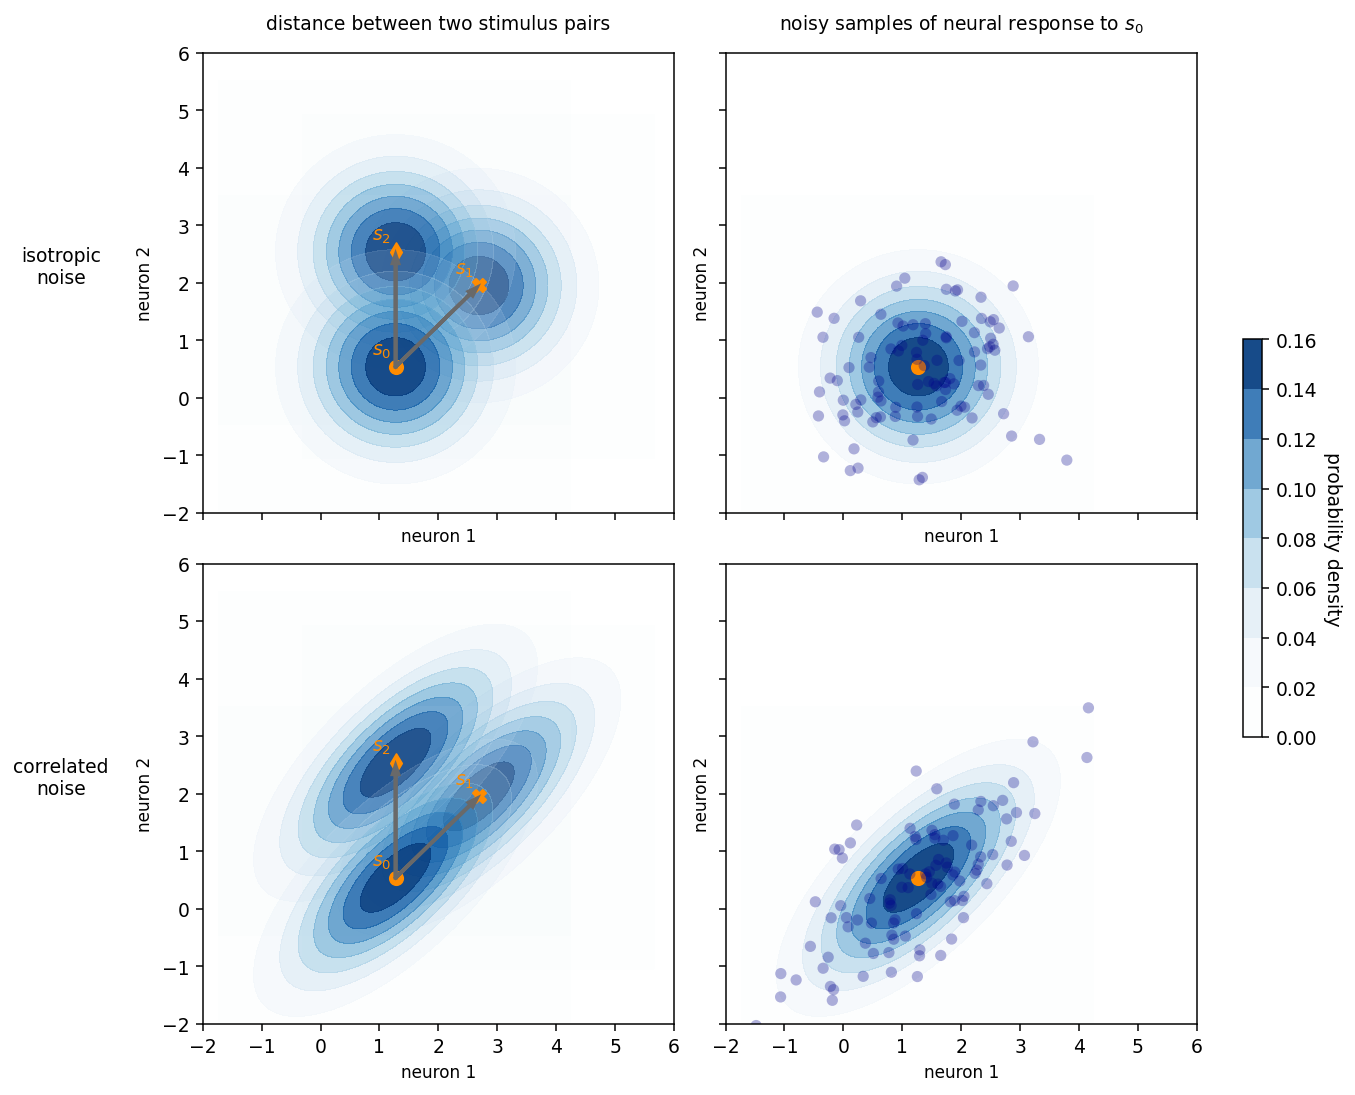

In [89]:
n_neurons=2
visualize_2d_noise(clean_dataset[n_neurons], isotropic_cov[n_neurons], correlated_cov[n_neurons], isotropic_noised_data[n_neurons], correlated_noised_data[n_neurons])

Let's visualize the covariance matrix for each type of noise distribution (row 1) and generate their corresponding samples using the 100-neuron dataset (row 2).
- For isotropic noise, the covariance between different neurons is always 0.
- For correlated noise, we have generated a covariance matrix such that the neighboring neurons tend to be correlated.

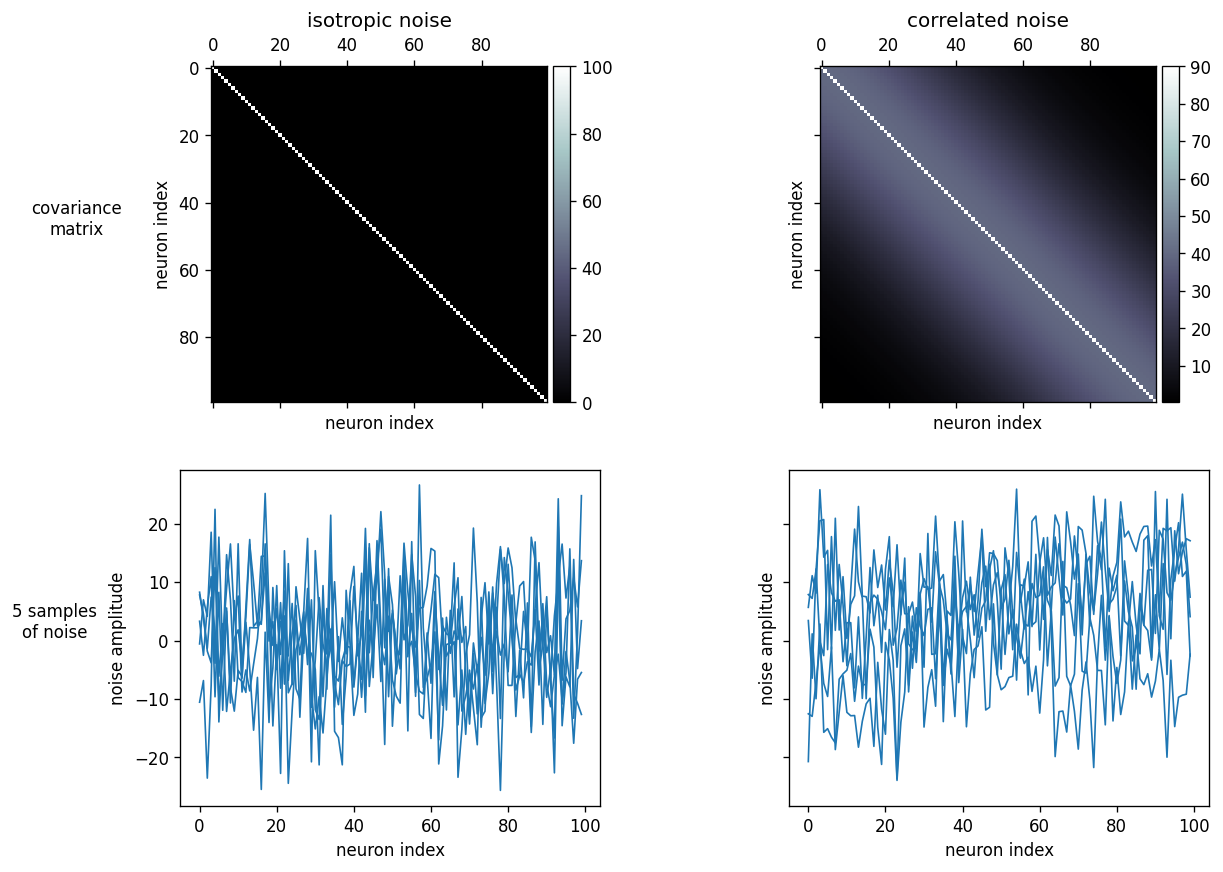

In [62]:
n_neurons=100
visualize_100d_noise(isotropic_cov[n_neurons], correlated_cov[n_neurons])

# Section 2. Distances and discriminability between a pair of stimuli</h3>

As we alluded to earlier, for a pair of stimuli, there is a strong dependence between their distance and discriminability (defined by the performance of a binary classifier on the stimulus pair). Moreover, matching the type of distance computed (euclidean vs. mahalanobis) and the noise distribution (isotropic vs. correlated) is important. <br>
Let's briefly review how to compute the euclidean and mahalanobis distance. Let the activity patterns of stimuli $j$ and $k$ be $\mathbf{b_j}$ and $\mathbf{b_k}$ respectively. <br>
- The squared euclidean distance is $$d^2_{\text{euclidean}}=||\mathbf{b_j}-\mathbf{b_k}||^2=(\mathbf{b_i} - \mathbf{b_j})(\mathbf{b_i} - \mathbf{b_j})^T$$
<br>
- The squared mahalanobis distance is $$d^2_{\text{mahalanobis}}=(\mathbf{b_i} - \mathbf{b_j})\Sigma^{-1}(\mathbf{b_i} - \mathbf{b_j})^T$$ where $\Sigma$ is the covariance matrix across the neurons. Taking the inverse of the covariance matrix makes the noise approximately independent and identically distributed. Intuitively, the noisier a neuron is, the more we down-weight its response.

## Coding exercise: Train your binary classifier of choice on the noisy neural data.

Train a binary classifier of your choice (linear or nonlinear) to classify each pair of stimuli using the noisy activity patterns.
- Feel free to use any off-the-shelf classifiers (e.g., from scikit-learn).
- An example of a linear classifier (Fisher's Linear Discriminant) is provided.

In [ ]:
class BinaryClassifier():
    """ignore if you are using off-the-shelf classifiers"""
    def __init__(self, *args, **kwargs):
        ###################################################################
        ## Fill out the following then remove
        raise NotImplementedError("Student exercise: initialize your classifier.")
        ###################################################################

    def fit(self, X, y):
        """
        Parameters:
            X: Training data. array-like of shape (n_samples, n_features)
            y: Labels. array-like of shape (n_samples,)
        """
        ###################################################################
        ## Fill out the following then remove
        raise NotImplementedError("Student exercise: fit the classifier to training data X .")
        ###################################################################

    def predict(self, X):
        """Predict class labels for samples in X."""
        ###################################################################
        ## Fill out the following then remove
        raise NotImplementedError("Student exercise: predict class labels.")
        ###################################################################

In [20]:
def compute_classifier_acc(classifier, neural_data, cov):
    """
    Compute the accuracy of a classifier for all combinations of stimulus pairs in the neural data.

    Parameters:
    - neural_data (xarray.DataArray): neural data with dimensions "stim" and "neuron".

    Returns:
    - acc (xarray.DataArray): Accuracy matrix with dimensions "stim1" and "stim2".
    """
    n_stimuli = len(np.unique(neural_data.stim.values))
    coords = {"stim1": np.arange(n_stimuli), "stim2": np.arange(n_stimuli)}
    acc_init = np.zeros([n_stimuli, n_stimuli])
    acc = np2xr(acc_init, coords)
    whitening_matrix = np.linalg.inv(np.linalg.cholesky(cov))
    whitened_data = neural_data.values @ whitening_matrix
    neural_data = xr.DataArray(whitened_data, dims=neural_data.dims, coords=neural_data.coords)

    for i_stim_idx, j_stim_idx in tqdm(combinations(np.arange(n_stimuli),2)):
        i_stim_pattern = neural_data.sel({"stim":i_stim_idx}) # xarray cannot select two non-unique indices at the same time
        j_stim_pattern = neural_data.sel({"stim":j_stim_idx})
        X = xr.concat([i_stim_pattern, j_stim_pattern], dim="stim")
        y = X.stim.values

        loo = LeaveOneOut()
        for i, (train_index, test_index) in enumerate(loo.split(X)):
            classifier.fit(X[train_index].values, y[train_index])
            pred = classifier.predict(X[test_index])
            acc.loc[i_stim_idx, j_stim_idx] += np.sum((pred==y[test_index]))
        acc.loc[i_stim_idx, j_stim_idx] = acc.loc[i_stim_idx, j_stim_idx]/len(y)
        acc.loc[j_stim_idx, i_stim_idx] = acc.loc[i_stim_idx, j_stim_idx]

    return acc

An example of a linear classifier (fisher's linear discriminant) is provided below.

In [63]:
classifier=LinearDiscriminantAnalysis('svd')

Execute this cell below to calculate the classifier performance on the noisy data for each pair of stimuli (generated by adding either isotropic or correlated noise).

In [64]:
acc = {}
for n_neurons in n_neurons_list:
    acc[n_neurons]={}
    acc[n_neurons]['isotropic'] = compute_classifier_acc(classifier, isotropic_noised_data[n_neurons], cov=isotropic_cov[n_neurons])
    acc[n_neurons]['correlated'] = compute_classifier_acc(classifier, correlated_noised_data[n_neurons], cov=correlated_cov[n_neurons])

45it [00:41,  1.09it/s]
45it [00:42,  1.07it/s]
45it [04:53,  6.53s/it]
45it [04:04,  5.44s/it]


Let's calculate the euclidean and mahalonobis distance of the **clean neural activity** patterns to study the relationship between euclidean / mahalanobis distance and classification accuracy.

In [47]:
rdm_euclidean, rdm_mahalanobis = {}, {}
for n_neurons in n_neurons_list:
    rdm_euclidean[n_neurons] = calc_rdm(clean_dataset[n_neurons], method='euclidean')
    rdm_mahalanobis[n_neurons] = calc_rdm(clean_dataset[n_neurons], method='mahalanobis', noise=np.linalg.inv(correlated_cov[n_neurons])) # plotting decoding accuracy from isotropic noise data

For each pair of stimuli, we can plot the decoding accuracy and the distance between them. We will generate four plots for each dataset, two noise distributions (isotropic or correlated) $\times$ two distance measures (euclidean or mahalanobis). Notice that:
- For data with isotropic noise, the euclidean distance predicts decoding accuracy better (higher correlation).
- For data with correlated noise, the mahalanobis distance that takes into account the noise covariance predicts decoding accuracy better.

Text(0.5, 0.98, '2 neurons')

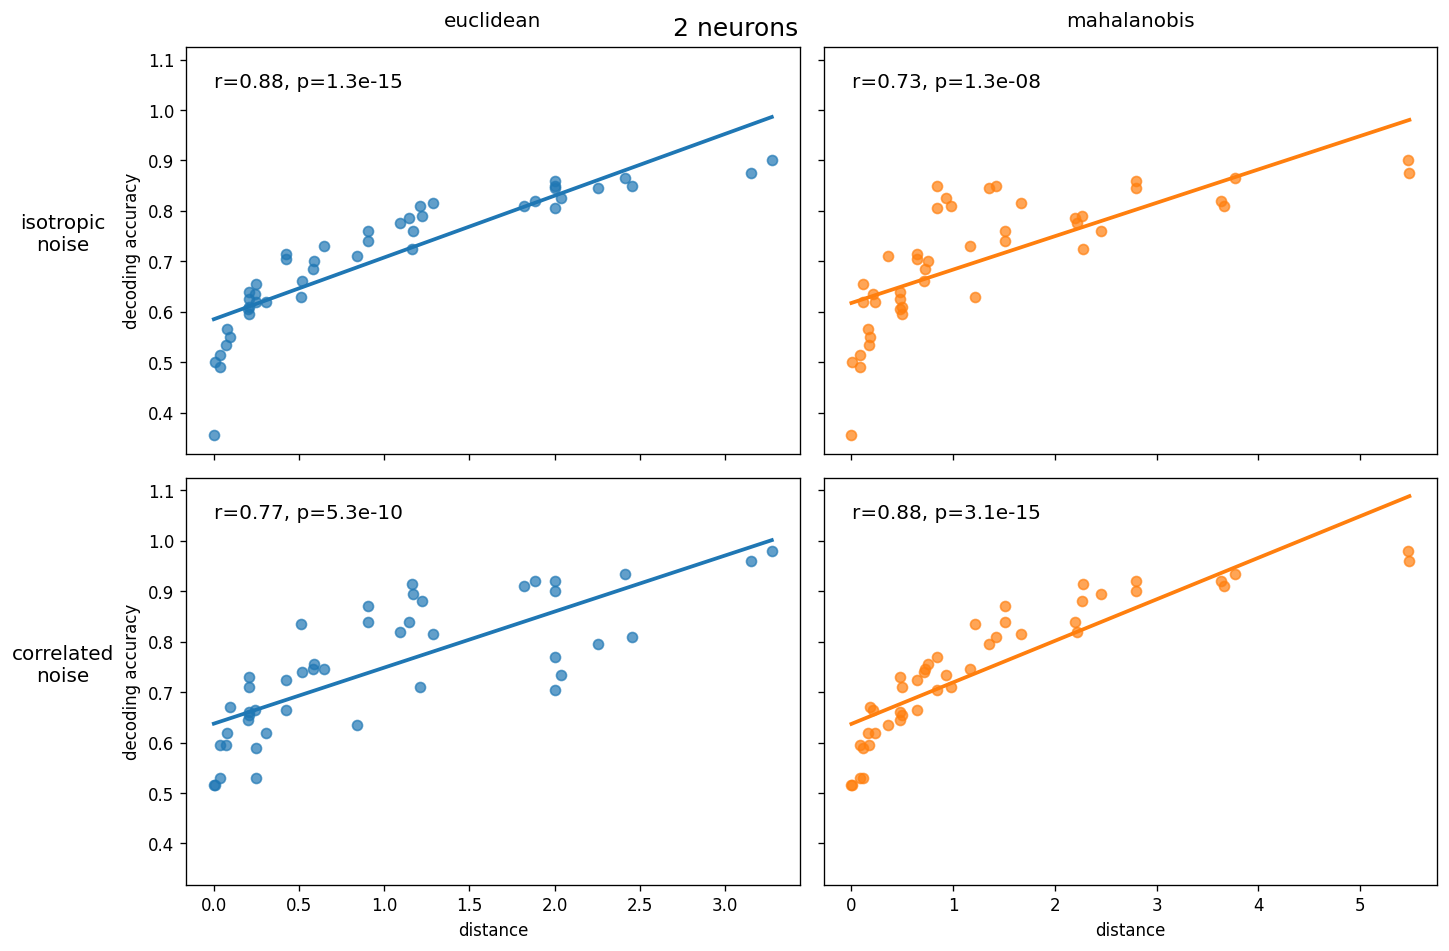

In [95]:
n_neurons = 2 # change to 100 to visualize the relationship between distance and decoding accuracy for the 100-neuron dataset
fig = plot_accuracy_against_distance(acc[n_neurons], rdm_euclidean[n_neurons], rdm_mahalanobis[n_neurons])
fig.suptitle(f"{n_neurons} neurons", fontsize=15)

# Section 3. Crossvalidated distances prevents the inflation of distance estimates by noise

Let's calculate the euclidean distance between noisy activity patterns and compare with the ground truth euclidean distance (determined by the clean activity patterns).

In [48]:
noisy_rdm_euclidean={}
for n_neurons in n_neurons_list:
    noisy_rdm_euclidean[n_neurons] = {}
    noisy_rdm_euclidean[n_neurons]['isotropic'] = calc_rdm(isotropic_noised_data[n_neurons], method='euclidean')
    noisy_rdm_euclidean[n_neurons]['correlated'] = calc_rdm(correlated_noised_data[n_neurons], method='euclidean')

/usr/local/lib/python3.10/dist-packages/numpy/core/numeric.py:407: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(res, fill_value, casting='unsafe')


We can plot the estimated Euclidean distance against the true Euclidean distance. Points falling on the diagonal line indicate an unbiased estimate of the distance; points above the diagonal line indicate an overestimation of the distance, and vice versa. <br>
**Notice that the estimated euclidean distance of noisy data in general yields higher than expected values**, especially for the 100-neuron dataset. To understand the positive bias of distances, imagine two activity patterns that are in truth identical. However, with the addition of the noise, the estimated distance between the noisy data will always be larger than 0. The noise makes the patterns dissimilar and inflates the distance (Walther et al. 2016). This effect is particularly pronounced in high-dimensional data.

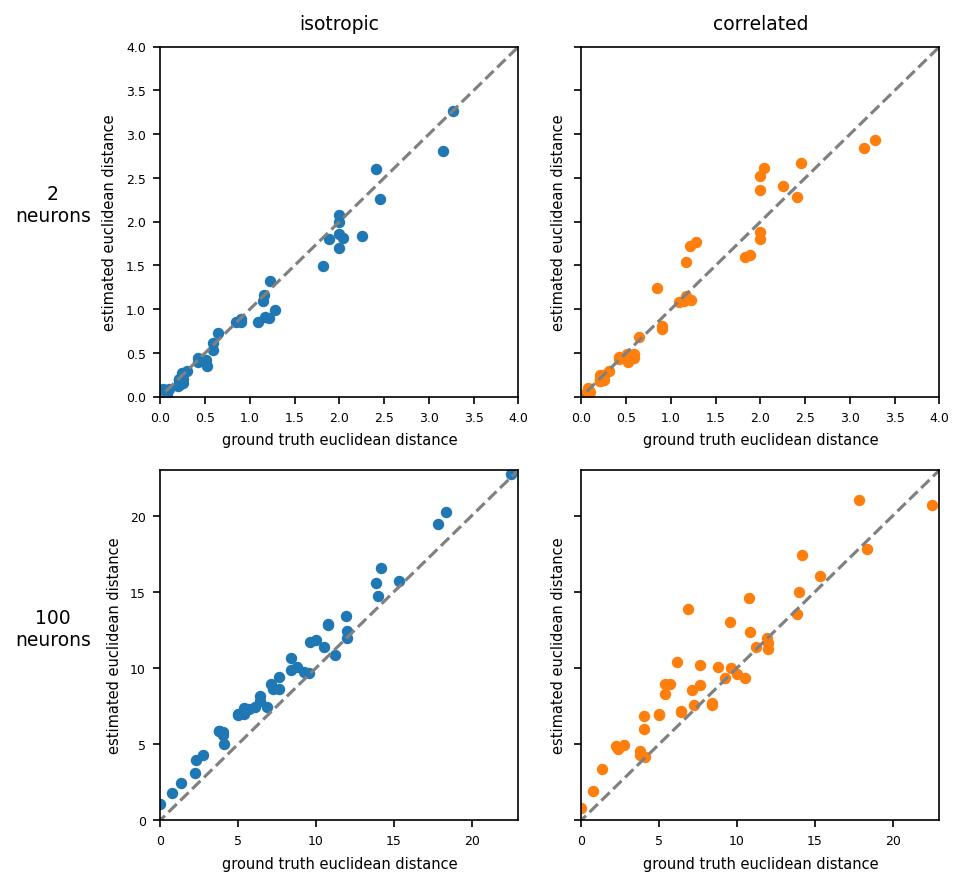

In [54]:
plot_estimated_distance(n_neurons_list, rdm_euclidean, noisy_rdm_euclidean, ylabel="estimated euclidean distance")

To obtain unbiased estimate, we can split the data into independent sets and to cross-validate the difference between patterns across the two sets (Allefeld and Haynes, 2014; Nili et al. 2014).<br>
The cross-validated squared euclidean (*crossclidean*) distance between two activity patterns $\mathbf{b_i}$ and $\mathbf{b_j}$ can be computed as: $$d^2_{\text{euclidean, crossvalidated}}=(\mathbf{b_i} - \mathbf{b_j})_\text{train}(\mathbf{b_i} - \mathbf{b_j})_\text{test}^T$$
where we partition the repeated measurements of the activity patterns into a training and testing set before computing the differenc vectors independently.

rsatoolbox already implemented the crossvalidated distance. The general distance measure is called *crossnobis*, short for *cross-validated mahalanobis distance*. If we assume the covariance noise structure is an identity matrix, then the crossnobis distance is equivalent to cross-validated euclidean distance.

In [55]:
noisy_rdm_crossclidean={}
for n_neurons in n_neurons_list:
    noisy_rdm_crossclidean[n_neurons] = {}
    noisy_rdm_crossclidean[n_neurons]['isotropic'] = calc_rdm(isotropic_noised_data[n_neurons], method='crossnobis', noise=None)
    noisy_rdm_crossclidean[n_neurons]['correlated'] = calc_rdm(correlated_noised_data[n_neurons], method='crossnobis', noise=None)

/usr/local/lib/python3.10/dist-packages/numpy/core/numeric.py:407: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(res, fill_value, casting='unsafe')


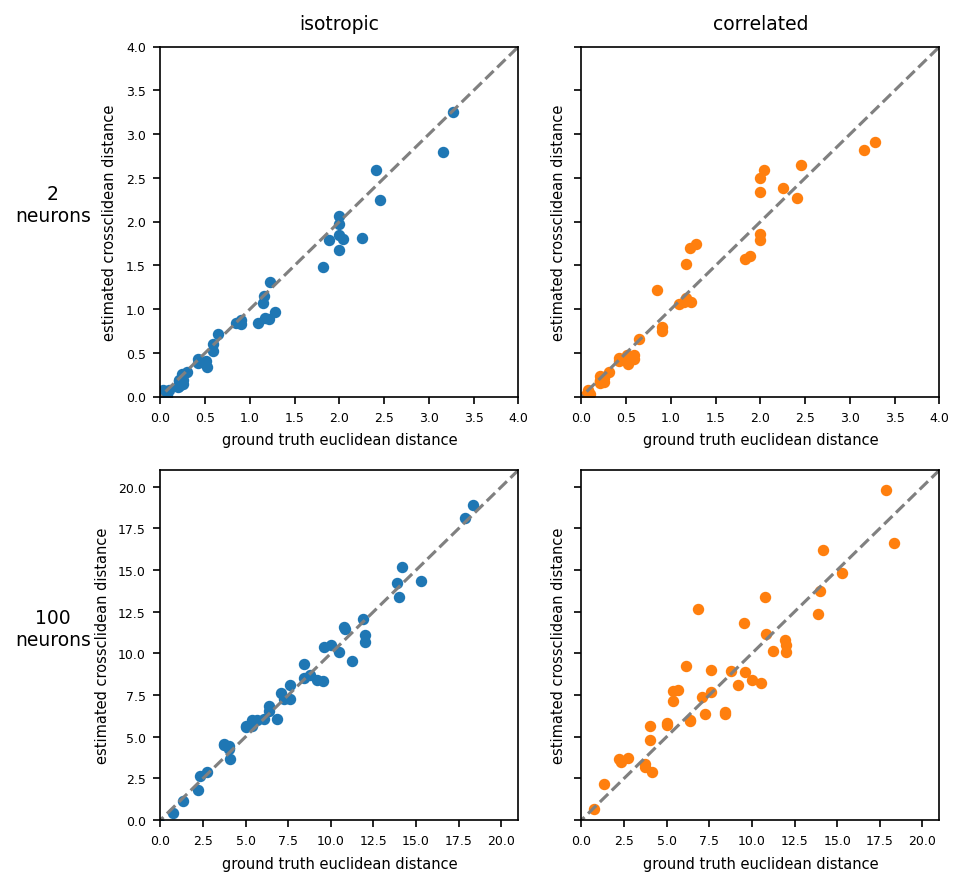

In [57]:
plot_estimated_distance(n_neurons_list, rdm_euclidean, noisy_rdm_crossclidean, ylabel="estimated crossclidean distance")

# Section 4. The Johnson-Lindenstrauss Lemma
The Johnson-Lindenstrauss Lemma says that random projections approximately preserve euclidean distances with some distortion. The distortion $\epsilon$ is bounded by the number of points in the original space, $n$, and the number of dimensions after the projection, $m$.
<br> We will see that we can embed points in a high-dimensional space into a reasonably low dimension.

We choose one pair of stimuli for illustration purpose. After we project the data into some dimension $d$ ($d=2,4,8,...,512$), we can calculate the euclidean distance between the stimulus pair in the projected space and compare with the distance in the original space. Notice that:
- the distance in the transformed space is close to the original distance for relatively small $k$.
- the bound does not depend on the dimension $d$ in the original space, so the dimension $k$ that preserves euclidean distance up to a small distortion for the 100-neuron dataset is not much larger than the one for the 2-neuron dataset.
- the distance between the two identical stimuli after random projection is still zero (set stim_idx = [0,9])

In [93]:
stim_idx = [0,1] # change stimulus index to visualize another pair of stimuli
n_dims_list = np.power(2, np.arange(1,10))
true_dist, projected_dist = {}, {}
for i, n_neurons in enumerate(n_neurons_list):
    data = clean_dataset[n_neurons].sel({"stim": stim_idx})
    # Let's first recalculate the ground truth euclidean rdm again, without normalization by the number of neurons this time.
    true_dist[n_neurons] = calc_rdm(data, method='euclidean', noise=None, normalize_by_channels=False).dissimilarities.item()

    projected_dist[n_neurons]=[]
    for n_dims in n_dims_list:
        A = np.random.normal(loc=0, scale=np.sqrt(1/n_dims), size=(n_neurons, n_dims))
        # transformed_neural_1kd = (neural_1kd.values @ A) * 1/np.sqrt(n_channels)
        transformed_data = (data.values @ A)
        transformed_data = np2xr(transformed_data, coords={'stim': data.stim.values, 'neuron': np.arange(n_dims)})
        rdm = calc_rdm(transformed_data, method='euclidean', noise=None, normalize_by_channels=False)
        projected_dist[n_neurons].append(rdm.dissimilarities.item())
    projected_dist[n_neurons] = np.array(projected_dist[n_neurons])

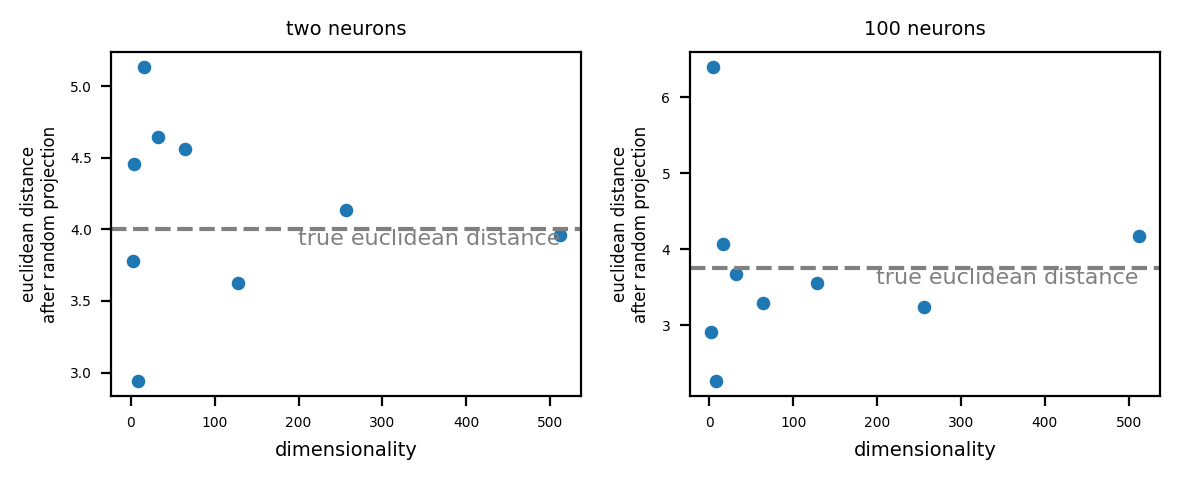

In [94]:
plot_distance_after_projection(true_dist, projected_dist, n_neurons_list, n_dims_list)

# Bibliography
1. Allefeld, C., & Haynes, J.-D. (2014). Searchlight-based multi-voxel pattern analysis of fmri by cross-validated Manova. NeuroImage, 89, 345–357. https://doi.org/10.1016/j.neuroimage.2013.11.043
2. Kriegeskorte, N., & Diedrichsen, J. (2019). Peeling the onion of brain representations. Annual Review of Neuroscience, 42(1), 407–432. https://doi.org/10.1146/annurev-neuro-080317-061906
3. Nili, H., Wingfield, C., Walther, A., Su, L., Marslen-Wilson, W., & Kriegeskorte, N. (2014). A toolbox for representational similarity analysis. PLoS Computational Biology, 10(4). https://doi.org/10.1371/journal.pcbi.1003553
4. Walther, A., Nili, H., Ejaz, N., Alink, A., Kriegeskorte, N., & Diedrichsen, J. (2016). Reliability of dissimilarity measures for multi-voxel pattern analysis. NeuroImage, 137, 188–200. https://doi.org/10.1016/j.neuroimage.2015.12.012